In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the content images folder on Google Drive
content_folder_path = '/content/drive/MyDrive/content_images/'
style_image_path = '/content/style_image.jpg'

In [4]:
def load_image(path, target_size=(300, 400)):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [5]:
def preprocess_input(x):
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [6]:
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [7]:
def build_style_transfer_model():
    base_model = VGG19(weights='imagenet', include_top=False)

    # Specify the layers for content and style representations
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # Get the outputs of the selected layers
    content_outputs = [base_model.get_layer(layer).output for layer in content_layers]
    style_outputs = [base_model.get_layer(layer).output for layer in style_layers]

    # Combine the inputs and outputs to create the model
    model_outputs = content_outputs + style_outputs
    model = Model(inputs=base_model.input, outputs=model_outputs)

    return model

In [8]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# Function to compute style loss
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 300 * 400
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [9]:
def total_variation_loss(x):
    a = K.square(x[:, :299, :399, :] - x[:, 1:, :399, :])
    b = K.square(x[:, :299, :399, :] - x[:, :299, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Function to define the total loss
def total_loss(content_image, style_image, combination_image, alpha=1e-4, beta=1e-2, gamma=1):
    content_loss_value = content_loss(content_image, combination_image)
    style_loss_value = sum([style_loss(style, combination_image) for style in style_image])
    tv_loss_value = total_variation_loss(combination_image)

    return alpha * content_loss_value + beta * style_loss_value + gamma * tv_loss_value

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [18]:
import os
from glob import glob

# Function to load multiple content images from a folder
def load_images_from_folder(folder_path, num_images=10, target_size=(300, 400)):
    images = []
    image_files = glob(os.path.join(folder_path, '*.jpg'))[:num_images]

    for file_path in image_files:
        img = image.load_img(file_path, target_size=target_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        images.append(img)

    return np.vstack(images)[:, :, :, :3]  # Ensure the shape is (num_images, height, width, channels)


# Function to perform style transfer
def style_transfer(content_folder, style_path, num_iterations=100):
    content_images = load_images_from_folder(content_folder, num_images=10)

    # Load style image from local path in Colab
    style_image_path = '/content/drive/MyDrive/style_image.jpg'
    style_image = load_image(style_image_path)

    # Initialize the combination images with the content images
    combination_images = K.variable(content_images)

    # Create the style transfer model
    model = build_style_transfer_model()

    # Define the optimizer
    optimizer = Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

    # Compute the loss
    loss = total_loss(content_images, style_image, combination_images)

    # Compute the gradients and updates
    grads = K.gradients(loss, combination_images)[0]
    fetch_loss_and_grads = K.function([combination_images], [loss, grads])

    for i in range(num_iterations):
        loss_value, grads_value = fetch_loss_and_grads([content_images])
        optimizer.apply_gradients([(grads_value, combination_images)])
        if i % 10 == 0:
            print("Iteration {}: Loss {}".format(i, loss_value))

    # Convert the combination images to regular numpy arrays
    img = deprocess_image(combination_images.numpy())

    # Display the result
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage
style_transfer('/content/drive/MyDrive/content_images/', '/content/drive/MyDrive/style_image.jpg', num_iterations=100)




InvalidArgumentError: ignored

Style Image:


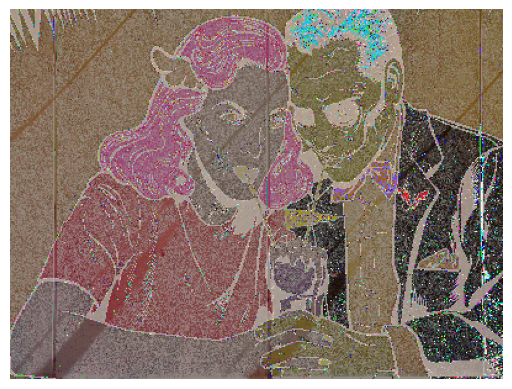

InvalidArgumentError: ignored

In [19]:
import os
from glob import glob

# Function to load multiple content images from a folder
def load_images_from_folder(folder_path, num_images=10, target_size=(300, 400)):
    images = []
    image_files = glob(os.path.join(folder_path, '*.jpg'))[:num_images]

    for file_path in image_files:
        img = image.load_img(file_path, target_size=target_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        images.append(img)

    return np.vstack(images)[:, :, :, :3]  # Ensure the shape is (num_images, height, width, channels)

# Function to save an image
def save_image(img, path):
    img = deprocess_image(img)
    img = Image.fromarray(img)
    img.save(path)

# Function to perform style transfer
def style_transfer(content_folder, style_path, num_iterations=100):
    content_images = load_images_from_folder(content_folder, num_images=10)

    # Load style image from local path in Colab
    style_image_path = '/content/drive/MyDrive/style_image.jpg'
    style_image = load_image(style_image_path)

    # Print style image
    print("Style Image:")
    plt.imshow(style_image[0].astype(np.uint8))
    plt.axis('off')
    plt.show()

    # Initialize the combination images with the content images
    combination_images = K.variable(content_images)

    # Create the style transfer model
    model = build_style_transfer_model()

    # Define the optimizer
    optimizer = Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

    # Compute the loss
    loss = total_loss(content_images, style_image, combination_images)

    # Compute the gradients and updates
    grads = K.gradients(loss, combination_images)[0]
    fetch_loss_and_grads = K.function([combination_images], [loss, grads])

    for i in range(num_iterations):
        loss_value, grads_value = fetch_loss_and_grads([content_images])
        optimizer.apply_gradients([(grads_value, combination_images)])
        if i % 10 == 0:
            print("Iteration {}: Loss {}".format(i, loss_value))

    # Convert the combination images to regular numpy arrays
    stylized_img = deprocess_image(combination_images.numpy())

    # Print the stylized image
    print("Stylized Image:")
    plt.imshow(stylized_img[0].astype(np.uint8))
    plt.axis('off')
    plt.show()

    # Save the stylized image
    save_image(stylized_img[0], '/content/drive/MyDrive/stylized_image.jpg')

# Example usage
style_transfer('/content/drive/MyDrive/content_images/', '/content/drive/MyDrive/style_image.jpg', num_iterations=100)
